In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib  # For model serialization
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def generate_dataset():
    """
    Generates a synthetic dataset with anomalies and saves it to 'enhanced_trade_data.csv'.
    """
    np.random.seed(42)
    num_records = 1000

    data = pd.DataFrame({
        'TransactionID': range(1, num_records + 1),
        'Date': pd.date_range(start='2023-01-01', periods=num_records, freq='D'),
        'Amount': np.random.normal(loc=10000, scale=2000, size=num_records).round(2),
        'Commodity': np.random.choice(['Gold', 'Silver', 'Oil', 'Wheat'], size=num_records),
        'Country': np.random.choice(['USA', 'China', 'Germany', 'India'], size=num_records),
        'TradeVolume': np.random.normal(loc=100, scale=20, size=num_records).round(2),
        'TradeType': np.random.choice(['Domestic', 'International'], size=num_records),
        'TransactionTime': np.random.uniform(0, 24, size=num_records).round(2)
    })

    contamination_rate = 0.10
    num_anomalies = int(contamination_rate * num_records)
     #WE ARE CREATING INDEXS WHICH ARE ANOMALIES!
    anomaly_indices = np.random.choice(data.index, num_anomalies, replace=False)
    # CREATINTG THEM AS ANOMALIES BY ADDING CONTAMINATION
    data.loc[anomaly_indices, 'Amount'] = data.loc[anomaly_indices, 'Amount'] * \
        np.random.choice([0.1, 10], size=num_anomalies)
    data.loc[anomaly_indices, 'TradeVolume'] = data.loc[anomaly_indices, 'TradeVolume'] * \
        np.random.choice([0.1, 10], size=num_anomalies)
    data.loc[anomaly_indices, 'TradeType'] = np.random.choice(['Domestic', 'International'], size=num_anomalies)
    data.loc[anomaly_indices, 'TransactionTime'] = np.random.choice([0, 23.99], size=num_anomalies)

    data['Anomaly'] = 0
    data.loc[anomaly_indices, 'Anomaly'] = 1

    data.to_csv('enhanced_trade_data.csv', index=False)

def load_and_preprocess_data(file_path):
    """
    Loads data from CSV file, encodes categorical variables, scales features, and returns processed data.
    Saves or loads encoders and scaler as needed.
    """
    data = pd.read_csv(file_path)

    # Load or create LabelEncoders
    encoders = {}
    categorical_features = ['Commodity', 'Country', 'TradeType']
    for feature in categorical_features:
        encoder_file = f'{feature}_encoder.joblib'
        if os.path.exists(encoder_file):
            encoder = joblib.load(encoder_file)
            print(f"{feature} encoder loaded from disk.")
        else:
            encoder = LabelEncoder()
            encoder.fit(data[feature])
            joblib.dump(encoder, encoder_file)
            print(f"{feature} encoder created and saved.")
        data[feature] = encoder.transform(data[feature])
        encoders[feature] = encoder

    # Convert 'Date' to ordinal
    data['Date'] = pd.to_datetime(data['Date']).map(pd.Timestamp.toordinal)

    labels = data['Anomaly'].values

    # Load or create scaler
    scaler_file = 'scaler.joblib'
    if os.path.exists(scaler_file):
        scaler = joblib.load(scaler_file)
        print("Scaler loaded from disk.")
    else:
        scaler = MinMaxScaler()
        scaler.fit(data.drop(['TransactionID', 'Anomaly'], axis=1))
        joblib.dump(scaler, scaler_file)
        print("Scaler created and saved.")

    data_scaled = scaler.transform(data.drop(['TransactionID', 'Anomaly'], axis=1))

    return data_scaled, labels, data, scaler, encoders

def split_data(data, labels, test_size=0.2, random_state=42):
    """
    Splits data and labels into training and testing sets, and returns indices.
    """
    indices = np.arange(len(data))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        data, labels, indices, test_size=test_size, random_state=random_state, stratify=labels)
    return X_train, X_test, y_train, y_test, idx_train, idx_test

def train_isolation_forest(X_train, contamination):
    """
    Trains an Isolation Forest model on the training data.
    """
    model = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contamination,
        random_state=42
    )
    model.fit(X_train)
    return model

def evaluate_isolation_forest(model, X):
    """
    Predicts anomalies using the trained Isolation Forest model.
    """
    predictions = model.predict(X)
    anomalies = (predictions == -1).astype(int)
    return anomalies

def train_one_class_svm(X_train, nu):
    """
    Trains a One-Class SVM model on the training data.
    """
    model = OneClassSVM(kernel="rbf", gamma='auto', nu=nu)
    model.fit(X_train)
    return model

def evaluate_one_class_svm(model, X):
    """
    Predicts anomalies using the trained One-Class SVM model.
    """
    predictions = model.predict(X)
    anomalies = (predictions == -1).astype(int)
    return anomalies

class Autoencoder(nn.Module):
    """
    Defines the Autoencoder neural network architecture.
    """
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train_autoencoder(model, dataloader, num_epochs, learning_rate=0.001):
    """
    Trains the Autoencoder model using the provided DataLoader.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for data_batch in dataloader:
            inputs = data_batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_autoencoder(model, data_tensor, threshold_quantile):
    """
    Evaluates the Autoencoder model and identifies anomalies based on reconstruction error.
    """
    with torch.no_grad():
        reconstructed = model(data_tensor)
        reconstruction_error = torch.mean((data_tensor - reconstructed) ** 2, dim=1)
    threshold = torch.quantile(reconstruction_error, threshold_quantile) # VALUE FOR EACH COLUMN THAT WILL ACTS AS CUTOFF!
    anomalies = (reconstruction_error > threshold).int() #ANOMALIES INDEX
    return anomalies.numpy(), reconstruction_error.numpy(), threshold.item() #RETURN AS NUMPY ARRAY

def compute_performance_metrics(y_true, y_pred):
    """
    Computes precision, recall, F1-score, accuracy, and confusion matrix for the predictions.
    """
    # Handle the case where there are no positive predictions
    if np.sum(y_pred) == 0:
        precision = 0
    else:
        precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    return precision, recall, f1, accuracy, confusion

def plot_data_distributions(data):
    """
    Plots histograms for numerical features to understand their distributions.
    """
    numeric_features = ['Amount', 'TradeVolume', 'TransactionTime']
    for feature in numeric_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data[feature], kde=True)
        plt.title(f'Histogram of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.show()

def plot_correlation_heatmap(data):
    """
    Plots a correlation heatmap of the features.
    """
    corr = data[['Amount', 'TradeVolume', 'TransactionTime', 'Anomaly']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

def plot_3d_pca_anomalies(X, anomalies, title):
    """
    Performs PCA on the data and plots the anomalies on the first three principal components in 3D.
    """
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    normal_points = X_pca[anomalies == 0]
    anomaly_points = X_pca[anomalies == 1]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(normal_points[:, 0], normal_points[:, 1], normal_points[:, 2], c='blue', label='Normal', s=10)
    ax.scatter(anomaly_points[:, 0], anomaly_points[:, 1], anomaly_points[:, 2], c='red', label='Anomalies', s=10)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)
    ax.legend()
    plt.show()

def predict_anomaly(input_data, scaler, encoders, iso_model, svm_model, ae_model, ae_threshold):
    """
    Predicts whether the input data point is an anomaly using the trained models.
    """
    # Preprocess input data
    input_df = pd.DataFrame([input_data])

    # Encode categorical features
    for feature, encoder in encoders.items():
        input_df[feature] = encoder.transform(input_df[feature])

    # Convert 'Date' to ordinal
    input_df['Date'] = pd.to_datetime(input_df['Date']).map(pd.Timestamp.toordinal)

    input_scaled = scaler.transform(input_df)

    # Isolation Forest Prediction
    iso_pred = iso_model.predict(input_scaled)
    iso_anomaly = int(iso_pred[0] == -1)

    # One-Class SVM Prediction
    svm_pred = svm_model.predict(input_scaled)
    svm_anomaly = int(svm_pred[0] == -1)

    # Autoencoder Prediction
    # we convert the data into a tenjsor before passing into pytorch model!
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    with torch.no_grad(): # NO GRADIENT DESCENT 
        reconstructed = ae_model(input_tensor)
        reconstruction_error = torch.mean((input_tensor - reconstructed) ** 2, dim=1)
    ae_anomaly = int(reconstruction_error.item() > ae_threshold)
    print(ae_anomaly)
    return {
        'Isolation Forest': iso_anomaly,
        'One-Class SVM': svm_anomaly,
        'Autoencoder': ae_anomaly
    }


Commodity encoder loaded from disk.
Country encoder loaded from disk.
TradeType encoder loaded from disk.
Scaler loaded from disk.


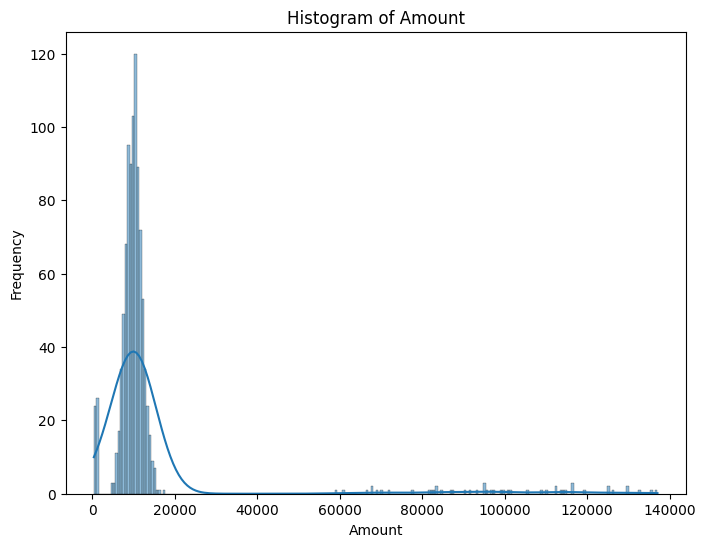

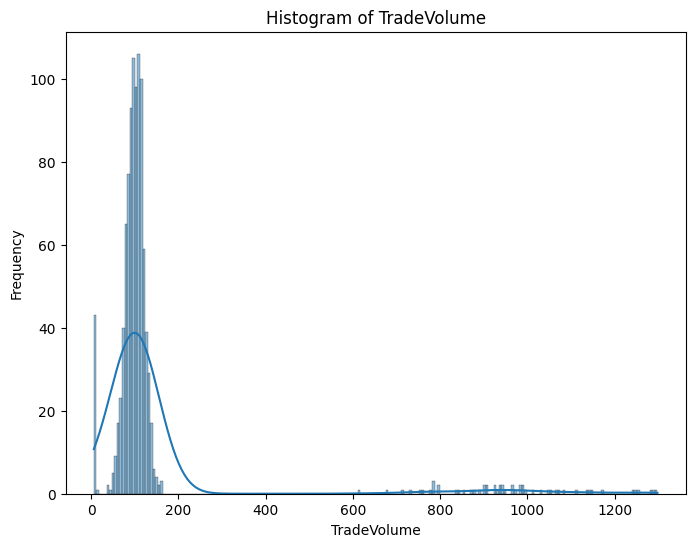

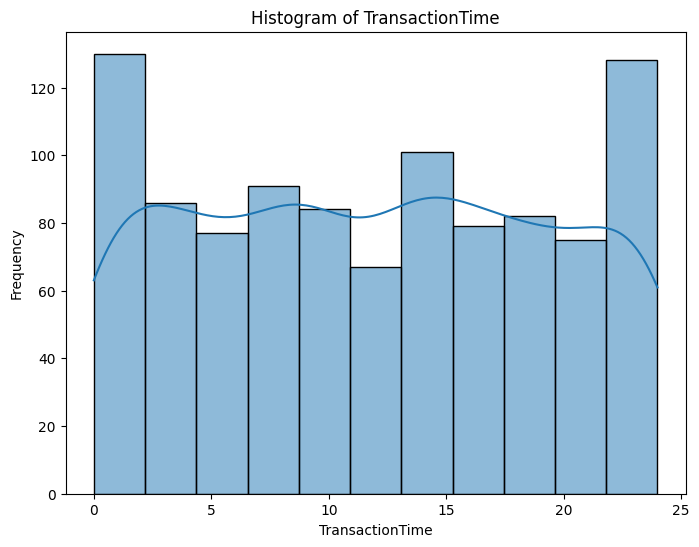

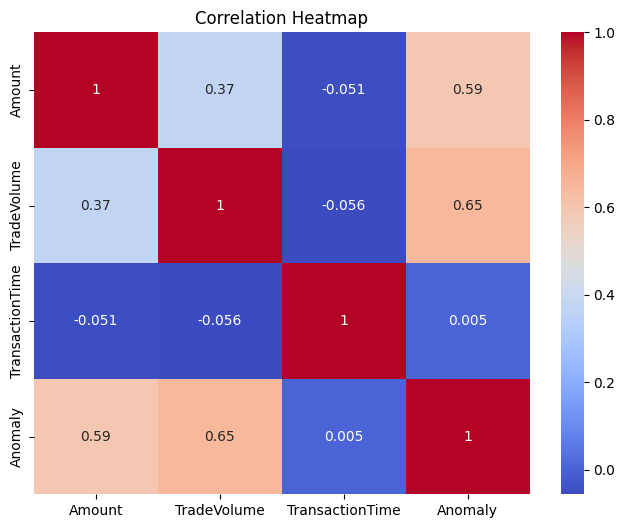

Isolation Forest model loaded from disk.
One-Class SVM model loaded from disk.
Autoencoder model loaded from disk.
           Model  Train Precision  Train Recall  Train F1-Score  Train Accuracy  Test Precision  Test Recall  Test F1-Score  Test Accuracy
Isolation Forest           0.9625        0.9625          0.9625          0.9925        0.863636         0.95       0.904762          0.980
   One-Class SVM           0.5250        0.5250          0.5250          0.9050        0.631579         0.60       0.615385          0.925
     Autoencoder           0.4125        0.4125          0.4125          0.8825        0.800000         0.80       0.800000          0.960


/tmp/ipykernel_55514/4169958859.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load(ae_model_file))


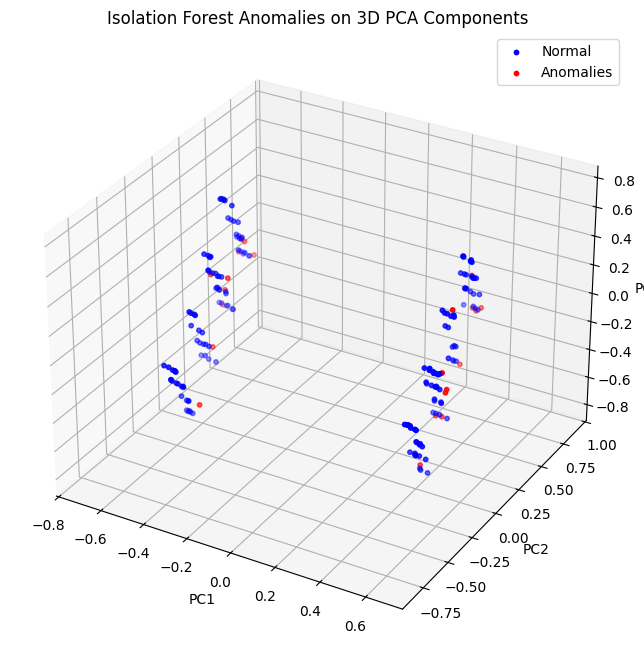

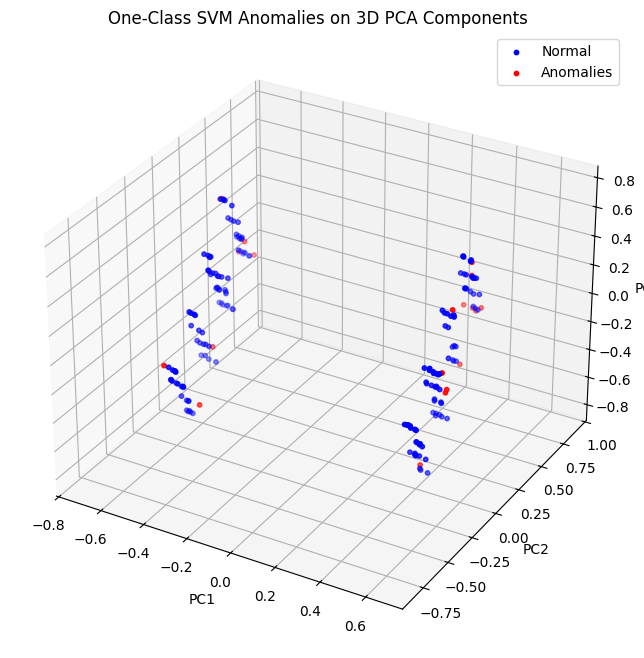

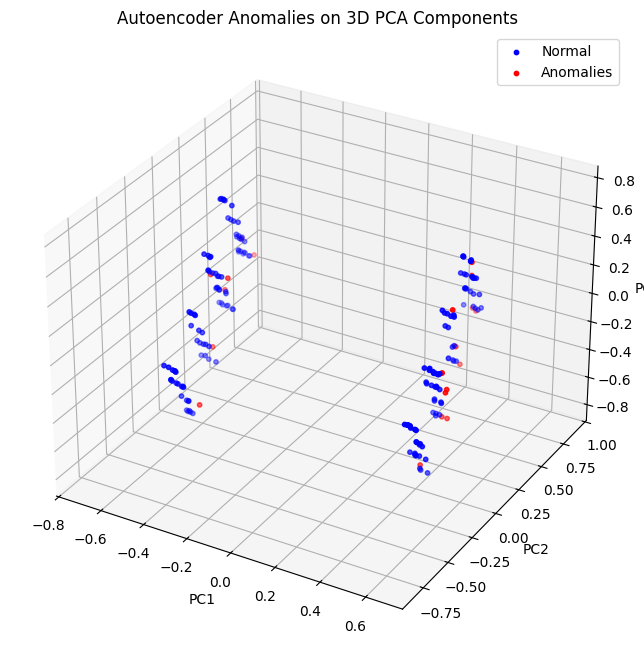

0

Anomaly Predictions for the new data point:
Isolation Forest: Normal
One-Class SVM: Normal
Autoencoder: Normal


In [14]:

if __name__ == "__main__":
    # Check if dataset exists; if not, generate it
    if not os.path.exists('enhanced_trade_data.csv'):
        generate_dataset()

    # Load and preprocess data
    data_scaled, labels, data_original, scaler, encoders = load_and_preprocess_data('enhanced_trade_data.csv')

    # Split data into training and testing sets, including indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = split_data(data_scaled, labels, test_size=0.2)

    # Visualize data distributions
    plot_data_distributions(data_original)

    # Plot correlation heatmap
    plot_correlation_heatmap(data_original)

    # ---- Isolation Forest ----
    iso_model_file = 'isolation_forest_model.joblib'
    if os.path.exists(iso_model_file):
        isolation_forest = joblib.load(iso_model_file)
        print("Isolation Forest model loaded from disk.")
    else:
        isolation_forest = train_isolation_forest(X_train, contamination=0.10)
        joblib.dump(isolation_forest, iso_model_file)
        print("Isolation Forest model trained and saved.")

    anomalies_iso_train = evaluate_isolation_forest(isolation_forest, X_train)
    anomalies_iso_test = evaluate_isolation_forest(isolation_forest, X_test)

    # ---- One-Class SVM ----
    svm_model_file = 'one_class_svm_model.joblib'
    if os.path.exists(svm_model_file):
        one_class_svm = joblib.load(svm_model_file)
        print("One-Class SVM model loaded from disk.")
    else:
        one_class_svm = train_one_class_svm(X_train, nu=0.10)
        joblib.dump(one_class_svm, svm_model_file)
        print("One-Class SVM model trained and saved.")

    anomalies_svm_train = evaluate_one_class_svm(one_class_svm, X_train)
    anomalies_svm_test = evaluate_one_class_svm(one_class_svm, X_test)

    # ---- Autoencoder ----
    input_dim = X_train.shape[1]
    autoencoder_model = Autoencoder(input_dim)
    ae_model_file = 'autoencoder_model.pth'
    if os.path.exists(ae_model_file):
        autoencoder_model.load_state_dict(torch.load(ae_model_file))
        autoencoder_model.eval()
        print("Autoencoder model loaded from disk.")
    else:
        # Prepare data for Autoencoder
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        train_dataset = TensorDataset(X_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        train_autoencoder(autoencoder_model, train_dataloader, num_epochs=500)
        torch.save(autoencoder_model.state_dict(), ae_model_file)
        print("Autoencoder model trained and saved.")

    # Evaluate Autoencoder
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    anomalies_ae_train, error_train, ae_threshold = evaluate_autoencoder(autoencoder_model, X_train_tensor, threshold_quantile=0.90)
    anomalies_ae_test, error_test, _ = evaluate_autoencoder(autoencoder_model, X_test_tensor, threshold_quantile=0.90)

    # Compute performance metrics for training set
    y_true_train = y_train
    # Isolation Forest
    precision_iso_train, recall_iso_train, f1_iso_train, accuracy_iso_train, confusion_iso_train = compute_performance_metrics(y_true_train, anomalies_iso_train)
    # One-Class SVM
    precision_svm_train, recall_svm_train, f1_svm_train, accuracy_svm_train, confusion_svm_train = compute_performance_metrics(y_true_train, anomalies_svm_train)
    # Autoencoder
    precision_ae_train, recall_ae_train, f1_ae_train, accuracy_ae_train, confusion_ae_train = compute_performance_metrics(y_true_train, anomalies_ae_train)

    # Compute performance metrics for test set
    y_true_test = y_test
    # Isolation Forest
    precision_iso_test, recall_iso_test, f1_iso_test, accuracy_iso_test, confusion_iso_test = compute_performance_metrics(y_true_test, anomalies_iso_test)
    # One-Class SVM
    precision_svm_test, recall_svm_test, f1_svm_test, accuracy_svm_test, confusion_svm_test = compute_performance_metrics(y_true_test, anomalies_svm_test)
    # Autoencoder
    precision_ae_test, recall_ae_test, f1_ae_test, accuracy_ae_test, confusion_ae_test = compute_performance_metrics(y_true_test, anomalies_ae_test)

    # Create DataFrame for metrics
    metrics_df = pd.DataFrame({
        'Model': ['Isolation Forest', 'One-Class SVM', 'Autoencoder'],
        'Train Precision': [precision_iso_train, precision_svm_train, precision_ae_train],
        'Train Recall': [recall_iso_train, recall_svm_train, recall_ae_train],
        'Train F1-Score': [f1_iso_train, f1_svm_train, f1_ae_train],
        'Train Accuracy': [accuracy_iso_train, accuracy_svm_train, accuracy_ae_train],
        'Test Precision': [precision_iso_test, precision_svm_test, precision_ae_test],
        'Test Recall': [recall_iso_test, recall_svm_test, recall_ae_test],
        'Test F1-Score': [f1_iso_test, f1_svm_test, f1_ae_test],
        'Test Accuracy': [accuracy_iso_test, accuracy_svm_test, accuracy_ae_test],
    })

    # Display metrics table
    print(metrics_df.to_string(index=False))

    # Prepare data for plotting
    data_test = data_original.iloc[idx_test].copy()
    data_test['Anomaly_ISO'] = anomalies_iso_test
    data_test['Anomaly_SVM'] = anomalies_svm_test
    data_test['Anomaly_AE'] = anomalies_ae_test

    # Plotting the PCA anomalies in 3D
    X_test_pca = X_test  # Using the scaled test data
    anomalies_list = [anomalies_iso_test, anomalies_svm_test, anomalies_ae_test]
    model_names = ['Isolation Forest', 'One-Class SVM', 'Autoencoder']

    for i, anomalies in enumerate(anomalies_list):
        plot_3d_pca_anomalies(
            X_test_pca,
            anomalies,
            f'{model_names[i]} Anomalies on 3D PCA Components'
        )

    # Example usage of predict_anomaly function
    new_data_point = {
        'Date': '2023-12-31',
        'Amount': 15000,
        'Commodity': 'Gold',
        'Country': 'USA',
        'TradeVolume': 120,
        'TradeType': 'International',
        'TransactionTime': 15.30
    }

    predictions = predict_anomaly(
        new_data_point, scaler, encoders, isolation_forest, one_class_svm, autoencoder_model, ae_threshold)

    print("\nAnomaly Predictions for the new data point:")
    for model_name, is_anomaly in predictions.items():
        result = 'Anomaly' if is_anomaly else 'Normal'
        print(f"{model_name}: {result}")